<a href="https://colab.research.google.com/github/SK-0911/Handwritten-Digit-Recognition/blob/main/IVP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
# from scipy.misc.pilutil import imresize
from PIL import Image #PIL=Python Imaging Library
import cv2  # version 3.2.0
from skimage.feature import hog #skimage has algos for image processing and hog-histogram of gradients, used for object detection
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle #used to randomly shuffle the rows of a dataset along with their corresponding labels or target values.

In [ ]:
from PIL import Image
from numpy import asarray


def imresize(arr,size):
	img=Image.fromarray(arr)
	img=img.resize(size)
	return asarray(img) #it resize the image and then converts the resized PIL Image back to a NumPy array

In [ ]:
DIGIT_WIDTH = 10
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28
CLASS_N = 10  # 0-9

In [ ]:
# This method splits the input training image into small cells (of a single digit) and uses these cells as training data.
# The default training image (MNIST) is a 1000x1000 size image and each digit is of size 10x20. so we divide 1000/10 horizontally and 1000/20 vertically.
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w // sx) for row in np.vsplit(img, h // sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

In [ ]:
def load_digits(fn):     #  responsible for loading digit images from a file and preparing them for training
    print('loading "%s for training" ...' % fn)
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (DIGIT_WIDTH, DIGIT_HEIGHT))       #splits the loaded image into individual digit cells using the split2d function based on w and h
    resized_digits = []
    for digit in digits:
        resized_digits.append(imresize(digit, (IMG_WIDTH, IMG_HEIGHT))) # Resize each digit cell to the specified dimensions using the imresize function and append it to the list of resized digit images
    labels = np.repeat(np.arange(CLASS_N), len(digits) / CLASS_N)
    return np.array(resized_digits), labels

In [ ]:
def pixels_to_hog_20(img_array):# HOG is used for object detection and image classification tasks.
    hog_featuresData = [] # empty list is created
    for img in img_array:
        fd = hog(img,
                 orientations=10,
                 pixels_per_cell=(5, 5),
                 cells_per_block=(1, 1))# function computes the gradient magnitude and orientation for each pixel,generates a histogram of gradient orientations within each cell.
        hog_featuresData.append(fd)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)

pixels_to_hog_20 aims to compute Histogram of Oriented Gradients (HOG) features from a collection of images represented as arrays.
 The function iterates over each image in the input array (img_array).

  For each image, it computes the HOG features using the hog function, specifying parameters such as the number of orientations, pixels per cell, and cells per block. **These parameters determine the level of detail captured in the HOG features and how they are computed.**
  
  The computed HOG features for each image are stored in a list named hog_featuresData. Once all images are processed, the list of HOG features is converted into a NumPy array of type float64 to ensure consistency. Finally, the function returns the HOG features as a NumPy array of type float32. Overall, this function provides a convenient way to extract HOG features from a set of images, which can then be used as input features for various machine learning algorithms.

In [ ]:
class KNN_MODEL():
    def __init__(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):#used to train the KNN model
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):#used to make predictions using the trained KNN model
        retval, results, neigh_resp, dists = self.model.findNearest(samples, self.k)
        return results.ravel()

In [ ]:
class SVM_MODEL():
    def __init__(self, num_feats, C=1, gamma=0.1):
        self.model = cv2.ml.SVM_create()
        self.model.setType(cv2.ml.SVM_C_SVC)
        self.model.setKernel(cv2.ml.SVM_RBF)  # SVM_LINEAR, SVM_RBF
        self.model.setC(C)
        self.model.setGamma(gamma)
        self.features = num_feats

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.model.predict(samples.reshape(-1, self.features))
        return results[1].ravel()

In [ ]:
def get_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []
    # find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r
        # this could vary depending on the image you are trying to predict
        # we are trying to extract ONLY the rectangles with images in it (this is a very simple way to do it)
        # we use heirarchy to extract only the boxes that are in the same global level - to avoid digits inside other digits

        if ((w * h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles

In [ ]:
def proc_user_img(img_file, model):# designed to process a user-provided image file (img_file) for digit recognition using a pre-trained model.
    print('loading "%s for digit recognition" ...' % img_file)
    im = cv2.imread(img_file)
    blank_image = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)#converting the image into grayscale.
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)
    #Perform a series of morphological operations (erode and dilate) using a predefined kernel to enhance the digit regions and remove noise.
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #Contours represent the boundaries of objects in the image.

    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    all_digits = ''

    for rect in digits_rectangles:#this draws a rectangle around the digit and extract the number
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit)
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))

        hog_img_data = pixels_to_hog_20([im_digit])
        pred = model.predict(hog_img_data)
        all_digits += str(int(pred[0]))
        cv2.putText(im, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        cv2.putText(blank_image, str(int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.imshow(im)
    cv2.imwrite("original_overlay.png", im)
    cv2.imwrite("final_digits.png", blank_image)
    print(all_digits)
    # cv2.destroyAllWindows()

poc_usr_img function processes a user-provided image, detects potential digit regions, recognizes digits within those regions using a pre-trained model, and outputs the recognized digits overlaid on the original image and as a separate image with isolated digits.

In [ ]:
def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]  # row-wise ordering

In [ ]:
def load_digits_custom(img_file):#used to process an image file containing digits for training a machine learning model
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)#reading the image file
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)#converting to grayscale
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    #Perform a series of morphological operations (erode and dilate) using a predefined kernel to enhance the digit regions and remove noise
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digits_rectangles = get_digits(contours, hierarchy)  # rectangles of bounding the digits in user image

    # sort rectangles according to x,y pos so that we can label them
    digits_rectangles.sort(key=lambda x: get_contour_precedence(x, im.shape[1]))

    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
        im_digit = imgray[y:y + h, x:x + w]
        im_digit = (255 - im_digit) #Inverts the color intensity of the digit region to enhance visibility.

        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index + 1) % 10 == 0:
            start_class += 1
    cv2.imwrite("training_box_overlay.png", im)

    return np.array(train_data), np.array(train_target)

train data shape (100, 28, 28)
test data shape (100,)


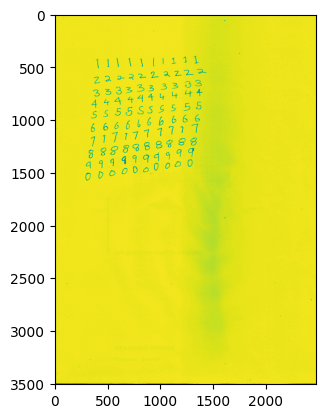

In [ ]:
TRAIN_MNIST_IMG = 'digits.png'
TRAIN_USER_IMG = 'custom_train_digits.jpg'
TEST_USER_IMG = 'test_image.png'

# digits, labels = load_digits(TRAIN_MNIST_IMG) #original MNIST data (not good detection)
digits, labels = load_digits_custom(TRAIN_USER_IMG)  # my handwritten dataset (better than MNIST on my handwritten digits)

print('train data shape', digits.shape)# this provides the dimension of the data
print('test data shape', labels.shape)

digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixels_to_hog_20(digits)
X_train, X_test, y_train, y_test = train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

Accuracy:  0.8787878787878788
loading "test_image.png for digit recognition" ...
7697043612138


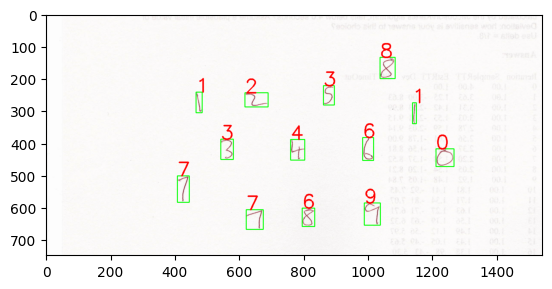

In [ ]:
model_knn = KNN_MODEL(k=5)#This line creates an instance of the KNN_MODEL class
model_knn.train(X_train, y_train)
preds_knn = model_knn.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds_knn))# uses the accuracy_score function from Scikit-learn to compare the true labels.

# model_knn = KNN_MODEL(k=5)
model_knn.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model_knn)

Accuracy:  0.7575757575757576
loading "test_image.png for digit recognition" ...
7697043612138


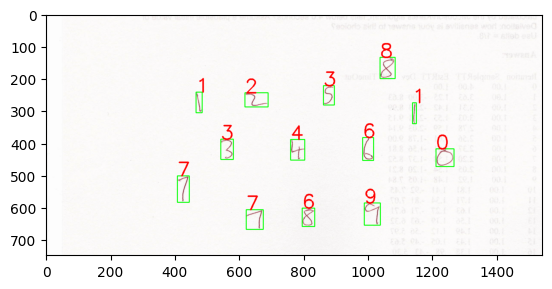

In [ ]:
model = SVM_MODEL(num_feats=train_digits_data.shape[1])#creates an instance of the SVM_MODEL class with the no. of features set to the no. of features in the training data .
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))

model = SVM_MODEL(num_feats=train_digits_data.shape[1])
model.train(train_digits_data, labels)
proc_user_img(TEST_USER_IMG, model)